
<br>

# Motivation 

 Linear systems of equations ($Ax=b$) play an important role in many areas of science and technology, including machine learning, solving partial differential equations, fitting polynomial curves, and analyzing electrical circuits. Variational quantum algorithms can be used to solve these linear systems of equations using NISQ (Noisy Intermediate Scale Quantum) devices. Variational quantum algorithm is a hybrid algorithm that finds the solution of a system using both classical and quantum computers. Given a guess or ansatz, the quantum processor calculates the system's expectation value with respect to an observable, typically the Hamiltonian, and a classical optimizer is used to optimize the guess. The approach is based on quantum mechanics variational method. Therefore, we explore the variational quantum linear solver algorithm for this task.


<br>

# The VQLS (Variational Quantum Linear Solver) Algorithm 

<br>


This notebok gives a detail description on how to convert the partial diferential equations to the linear system of equations such that we can employ VQLS to solve them faster than the current day classical computers.


<font color='red'>Note: This derivation is not mandatory for understanding and executing the algorithm and is only included for the sake of completeness of theory
</font>

Consider the one-dimensional diffusion equation
                            

$$
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}, \quad 0 \le x \le L, \quad t \ge 0
\tag{1}
$$

where $u = u(x,t)$ is the dependent variable, and $\alpha$ is the constant coefficient. The equation (1) is a model of transient heat conduction in a slab of material with thickness $L$. The material property $\alpha$ is the thermal diffusivity. Solution to (1) requires intital and boundary conditions. 

$$
u(0,t) = u_0, \quad u(L,t) = u_L, \quad u(x,0) = u_0(x)
\tag{2}
$$


The finite difference method is one of the several techniques for obtaining numerical solutions to heat equation (1). In all numerical solutions the continuous partial differential equation (PDE) is replaced with a discrete approximation. Two key parameters of the mesh are $\Delta x$, the local distance between adjacent points in space, and $\Delta t$, the local distance between adjacent time steps.

The finite difference method method involves using discrete approximations like 

$$

\frac{\partial u}{\partial x} \approx \frac{u(x+\Delta x)-u(x)}{\Delta x}
\tag{3}
$$



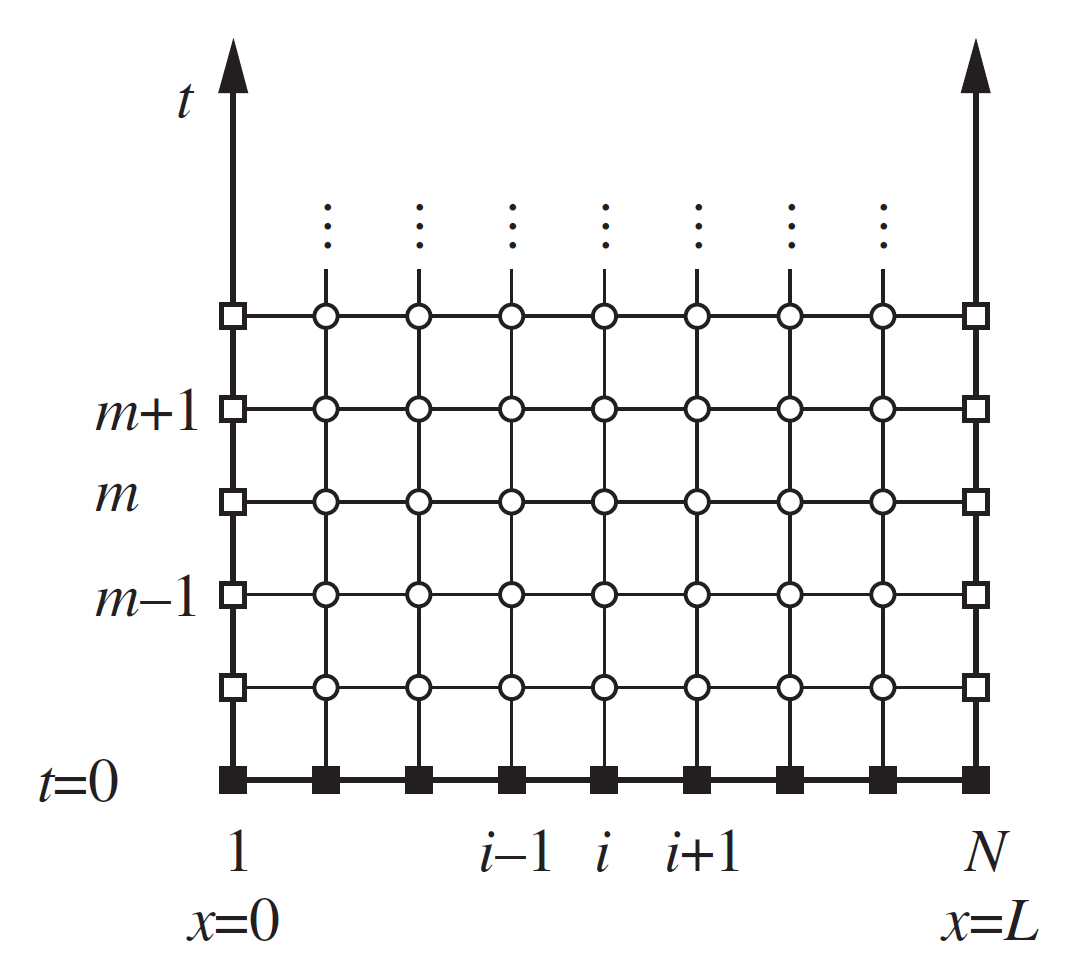

In [24]:
from IPython.display import Image
Image(r"Images/grid.png",height= 500,width=500)

Fig: 1. For the purpose of solving the one-dimensional heat equation, mesh on a semi-infinite strip. The locations of the (known) initial values are indicated by the solid squares. The locations of the (known) boundary values are indicated by the open squares. The inner points where the finite difference approximation is determined are indicated by the open circles.

$$
\begin{aligned}
& \text {Table 1: Notation }\\
&\begin{array}{cc}
\hline \hline \text { Symbol } & \text { Meaning }  \\
\hline u(x,t) & \mathrm{continuous \; solution \; (true \; solution)}  \\
u(x_i,t_m) & \mathrm{continuous \; solution \; evaluated \; at \; mesh \; points} \\
u_i^m & \mathrm{approximate \; numerical \; solutions \; obtained \; by \; solving \; the \; finite-difference \; equations}\\
\hline
\end{array}
\end{aligned}
$$


We now introduce the three difference methods:

(i) First order forward difference - consider a Taylor series expansion $u(x)$ about the point $x_i$ with $\delta x =  \Delta x $

$$
u(x_i+\Delta x) = u(x_i)+\Delta x \frac{\partial u}{\partial x}\Bigr|_{x_i} + \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} + \frac{\Delta x^3}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{4}
$$


solving for $(\partial u/\partial x)_{x_i}$ 

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} = \frac{u(x_i+\Delta x)-u(x_i)}{\Delta x} - \frac{\Delta x}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \frac{\Delta x^2}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{5}
$$

By substituting the approximate solution for the exact solution $u_i \approx u(x_i)$ and $u_{i+1} \approx u(x+\Delta x)$.

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} \approx \frac{u_{i+1}-u_i}{\Delta x} - \frac{\Delta x}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \frac{\Delta x^2}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{6}
$$

The mean value theorem can be used to replace the higher order derivatives

$$
\frac{\Delta x}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \frac{\Delta x^2}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+... = \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{\zeta}
$$
where $x_i\le \zeta \le x_{i+1}$. Thus 

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} - \frac{u_{i+1}-u_i}{\Delta x} \approx \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{\zeta}
\tag{7}
$$

The term on the right hand side is caled the $ \textit{truncation error} $ of the finite difference approximation.

Although the exact magnitude of the truncation error cannot be known (unless the true solution $u(x,t)$ is available in analytical form), the big $O$ notation can be used to express the dependence
of the truncation error on the mesh spacing. The truncation error is simply written as

$$
 \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{\zeta} = O(\Delta x^2)
$$

using big $O$ notation, equation (6) can be written as,

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} \approx \frac{u_{i+1}-u_i}{\Delta x} + O(\Delta x)
\tag{8}
$$


(ii) First order backward difference

An alternative first order finite difference formula is obtained if the Taylor series like that in equation (4) is written with $\delta x = - \Delta x $.

$$
u_{i-1} = u_i-\Delta x \frac{\partial u}{\partial x}\Bigr|_{x_i} + \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \frac{\Delta x^3}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{9}
$$

Note that we have alternate signs of terms on the right hand side. solving for $(\partial u/\partial x)_{x_i}$ to get

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} = \frac{u_i-u_{i-1}}{\Delta x} + \frac{\Delta x}{2} \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \frac{\Delta x^2}{3!} \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{10}
$$

using the big $O$ ntation

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} \approx \frac{u_i-u_{i-1}}{\Delta x} + O(\Delta x)
\tag{11}
$$

This is called the $\textit{backward difference}$ fornula because it involves the values of $u$ at $x_i$ and $x_{i-1}$. 


(iii) First order central difference

Writing the Taylor series expansions for $u_{i+1}$ and $u_{i-1}$

$$
u_{i+1} = u_i+\Delta x \frac{\partial u}{\partial x}\Bigr|_{x_i} + \Delta x^2 \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} + \Delta x^3 \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{12}
$$

$$
u_{i-1} = u_i-\Delta x \frac{\partial u}{\partial x}\Bigr|_{x_i} + \Delta x^2 \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} - \Delta x^3 \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
\tag{13}
$$

subtracting equation (13) from equation (12) yields

$$
u_{i+1}-u_{i-1} = 2 \Delta x \frac{\partial u}{\partial x}\Bigr|_{x_i}+2\Delta x^3 \frac{\partial^3 u}{\partial x^3}\Bigr|_{x_i}+...
$$

solving for $(\partial u/\partial x)_{x_i}$ and using big $O$ notation

$$
\frac{\partial u}{\partial x}\Bigr|_{x_i} = \frac {u(x_i+\Delta x)-u(x_i-\Delta x)}{2 \Delta x} + O(\Delta x^2)
\tag{14}
$$

With this we have seen the three different schemes for finite difference methods but we have second order partial differential equation in the heat equation (1), so we also need to look at the second order difference.

Second order central difference is obtained by adding the equations (12) and (13),

$$
u_{i+1}+u_{i-1} = 2 u_i + 2\Delta x^2 \frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i}+\frac {2\Delta x^4}{4!} \frac{\partial^4 u}{\partial x^4}\Bigr|_{x_i}+...
$$

solving for $(\partial^2 u/\partial x^2)_{x_i}$ gives 

$$
\frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} \approx \frac {u_{i+1}-2u_i+u_{i-1}}{\Delta x^2}+\frac{\Delta x^2}{12}\frac{\partial^4 u}{\partial x^4}\Bigr|_{x_i}
$$

Or, using order notation,

$$
\frac{\partial^2 u}{\partial x^2}\Bigr|_{x_i} \approx \frac {u_{i+1}-2u_i+u_{i-1}}{ \Delta x^2}+O(\Delta x^2)
\tag{15}
$$


We use second order central difference in space and backward difference in time to discretize the equation (1). Approximating the time derivative in equation (1) with a backward difference

$$
\frac{\partial u}{\partial t}\Bigr|_{t_{m+1},x_i} \approx \frac{u_i^m-u_i^{m-1}}{\Delta t} + O(\Delta t)
\tag{16}
$$

Now, substituting equations (16) and (15) into equation (1), we get

$$
\frac{u_i^m-u_i^{m-1}}{\Delta t} = \alpha \frac {u_{i-1}^m-2u_i^m+u_{i+^1}^m}{ \Delta x^2} + O(\Delta t)+O(\Delta x^2)
\tag{17}
$$

To see the system of equations, we drop the truncation error terms from the equation (17),

$$
-\frac{\alpha}{\Delta x^2}u_{i-1}^m + (\frac{1}{\Delta t}+\frac{2\alpha}{\Delta x^2})u_i^m - \frac{\alpha}{\Delta x^2}u_{i+1}^m = \frac{1}{\Delta t}u_i^{m-1}
\tag{18} 
$$

The system of equations can be represented in matrix form as

\begin{align*}
          \begin{bmatrix}
           b_1 & c_1 & 0 & 0 & 0 & 0\\
           a_2 & b_2 & c_2 & 0 & 0  & 0 \\
           0 & a_3 & b_3 & c_3 & 0 & 0 \\
           0 & 0 & \ddots & \ddots & \ddots & 0\\
           0 & 0 & 0 & a_{N-1} & b_{N-1} & c_{N-1} \\
           0 & 0  & 0  & 0 & a_N & b_N 
         \end{bmatrix}
          \begin{bmatrix}
           u_1 \\
           u_2 \\
           u_3 \\
           \vdots \\
           u_{N-1}\\
           u_N
         \end{bmatrix} =
        \begin{bmatrix}
           d_1 \\
           d_2 \\
           d_3 \\
           \vdots \\
           d_{N-1}\\
           d_N
         \end{bmatrix}     
         \tag{19}
\end{align*}

where the coefficients of the interior nodes with $i = 2,3,...,N-1$ are

\begin{align*}
a_i &= -\alpha/\Delta x^2 \\
b_i &= (1/\Delta t) + (2\alpha/\Delta x^2) \\
c_i &= -\alpha/\Delta x^2 \\
d_i &= (1/\Delta t)u_i^{m-1} \\
\end{align*}

For the Dirichlet boundary conditions in equation (2), the values of coefficients take

$$
b_1 = 1, \quad c_1= 0, \quad d_1= u_0 \\
a_N = 0, \quad b_N = 1, \quad d_n = u_L
$$

With that the equation (19) takes the form,

\begin{align*}
          \begin{bmatrix}
           1 & 0 & 0 & 0 & 0 & 0\\
           a_2 & b_2 & c_2 & 0 & 0  & 0 \\
           0 & a_3 & b_3 & c_3 & 0 & 0 \\
           0 & 0 & \ddots & \ddots & \ddots & 0\\
           0 & 0 & 0 & a_{N-1} & b_{N-1} & c_{N-1} \\
           0 & 0  & 0  & 0 & 0 & 1 
         \end{bmatrix}
          \begin{bmatrix}
           u_1 \\
           u_2 \\
           u_3 \\
           \vdots \\
           u_{N-1}\\
           u_N
         \end{bmatrix} =
        \begin{bmatrix}
           u_0 \\
           d_2 \\
           d_3 \\
           \vdots \\
           d_{N-1}\\
           u_L
         \end{bmatrix}     
         \tag{19}
\end{align*}


The interactive plot given below illustrates the above linear system of equation and it's solution as the time progresses. One can also play around with the parameters. 

In [1]:
# LIBRARY
# vector manipulation
import numpy as np
# math functions
import math 

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

N=30 # Number of grid points
Nt=100 
h=1/N
k=1/Nt
r=k/(h*h)
time_steps=50 # Number of time steps
fig = plt.figure(figsize=(12,6))

w=np.zeros((N+1,time_steps+1))
b=np.zeros(N-1)
time=np.arange(0,(time_steps+.5)*k,k)
x=np.arange(0,1.0001,h)

w=np.zeros((N+1,time_steps+1))
b=np.zeros(N-1)

# Initial Condition
for i in range (1,N):
    w[i,0]=2*x[i]
    if x[i]>0.5:
        w[i,0]=2*(1-x[i])
    

# Boundary Condition
for k in range (0,time_steps):
    w[0,k]=0
    w[N,k]=0


A=np.zeros((N-1,N-1))
for i in range (0,N-1):
    A[i,i]=1+2*r

for i in range (0,N-2):           
    A[i+1,i]=-r
    A[i,i+1]=-r

Ainv=np.linalg.inv(A)   


for j in range (1,time_steps+1):
    b[0]=r*w[0,j]
    b[N-2]=r*w[N,j]
    w[1:(N),j]=np.dot(Ainv,w[1:(N),j-1]+b)
def series(j):
    plt.plot(x,w[:,j],'*:',label='t[%s]=%s'%(j,time[j]))
    plt.xlabel('x')
    plt.ylabel('w')
    plt.ylim(0,1)
    plt.title("Solution profile")
    plt.legend(bbox_to_anchor=(-.4, 1), loc=2, borderaxespad=0.)
interact(series, j = (1,time_steps,1));

<Figure size 864x432 with 0 Axes>

interactive(children=(IntSlider(value=25, description='j', max=50, min=1), Output()), _dom_classes=('widget-in…

With that we completed the theory of VQLS. In the other two notebooks we will have a look at the global and local cost function of the algorithm.

 - <a href="https://www.researchgate.net/publication/265202152_Finite-Difference_Approximations_to_the_Heat_Equation">Finite difference methods</a>
 - <a href="https://john-s-butler-dit.github.io/NumericalAnalysisBook/Chapter%2008%20-%20Heat%20Equations/802_Heat%20Equation-%20BTCS.html"> Code for the interactive terminal</a>

This notebook was compiled by Dr. Bharadwaj Chowdary Mummaneni, Quantum computing, Fraunhofer IAO.